In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import random

In [23]:
tf.random.set_seed(50)

In [24]:
dataset, info = tfds.load('eurosat', with_info=True, as_supervised=True)
full_ds = dataset['train']

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
image_shape = info.features['image'].shape
image_dtype = info.features['image'].tf_dtype

print("===== EuroSAT Dataset Info =====")
print(f"Number of examples: {num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Image shape: {image_shape}")
print(f"Image dtype: {image_dtype}")

===== EuroSAT Dataset Info =====
Number of examples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Image shape: (64, 64, 3)
Image dtype: <dtype: 'uint8'>


In [25]:
# Resize and normalize

def resize_and_rescale(image, label, target=224):
    image = tf.image.resize(image, [target, target])    #resize images from 64×64 to 224×224
    # image = tf.cast(image, tf.float32) / 255.0     #convert pixel type
    return image, label

In [26]:
full_ds = full_ds.map(resize_and_rescale)

In [27]:
num_examples = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * num_examples)  
val_size   = int(0.15 * num_examples)  

# 70% train, 15% val, 15% test

train_ds = full_ds.take(train_size)
# Remaining 30%
remaining = full_ds.skip(train_size)

val_ds = remaining.take(val_size)

test_ds = remaining.skip(val_size)

# how many examples in each split
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count   = tf.data.experimental.cardinality(val_ds).numpy()
test_count   = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Train examples: {train_count}, Val examples: {val_count}, Test examples: {test_count}")

Train examples: 18900, Val examples: 4050, Test examples: 4050


In [28]:
# Inspect class counts (detect imbalance)
counts = collections.Counter() #dictionary-like object that counts occurrences of items
y_train_list = []


for _, lbl in tfds.as_numpy(train_ds):
    counts[int(lbl)] += 1
    y_train_list.append(int(lbl))

print("Per-class counts (train):")
for cls in sorted(counts.keys()):
    print(f"  class {cls}: {counts[cls]} images")


Per-class counts (train):
  class 0: 2122 images
  class 1: 2143 images
  class 2: 2067 images
  class 3: 1756 images
  class 4: 1756 images
  class 5: 1382 images
  class 6: 1718 images
  class 7: 2095 images
  class 8: 1754 images
  class 9: 2107 images


In [29]:
# no class imbalance, so we'll apply light augmentation just to
# improve model training and generalization and reduce overfitting

#minimal light augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [30]:
#apply augmentation to the training dataset only

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y))

In [31]:
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


In [32]:
# load pretrained resnet model 

ResNet = ResNet50(
    weights="imagenet",
    include_top=False,  #removes the original ImageNet classification head
    input_shape=[224,224,3]
)

ResNet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [33]:
# Build the model

ResNet.trainable = False    #freeze the pretrained weights against modifs

#input layer
inputs = Input(shape=(224,224,3))

#preprocessing layer for resnet
preprocess_imgs = Lambda(preprocess_input)(inputs)

#pass through resnet
resnet_features = ResNet(preprocess_imgs, training=False)

#pooling layer
pooled = GlobalAveragePooling2D()(resnet_features)

#final
predictionLayer = Dense(10, activation='softmax')(pooled)


ResNetModel = Model(inputs=inputs, outputs=predictionLayer)

ResNetModel.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile model (optimizer updates model's weights to reduce loss)

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
ResNetModel.compile(optimizer = optimizer, loss ="sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
# Train model

Batch_size = 64
train_ds = train_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

history = ResNetModel.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - accuracy: 0.8929 - loss: 0.3509 - val_accuracy: 0.9383 - val_loss: 0.1907
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.9456 - loss: 0.1628 - val_accuracy: 0.9427 - val_loss: 0.1714
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 844s 3s/step - accuracy: 0.9548 - loss: 0.1388 - val_accuracy: 0.9541 - val_loss: 0.1447
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 874s 3s/step - accuracy: 0.9613 - loss: 0.1175 - val_accuracy: 0.9526 - val_loss: 0.1443
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1515s 5s/step - accuracy: 0.9646 - loss: 0.1068 - val_accuracy: 0.9538 - val_loss: 0.1430
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2496s 8s/step - accuracy: 0.9634 - loss: 0.1058 - val_accuracy: 0.9578 - val_loss: 0.1312
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2593s 9s/step - accuracy: 0.9665 - loss: 0.0973 - val_accuracy: 0.9595 - val_loss: 0.1245
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - accuracy: 0.9715 - loss: 0.0873 - val_a

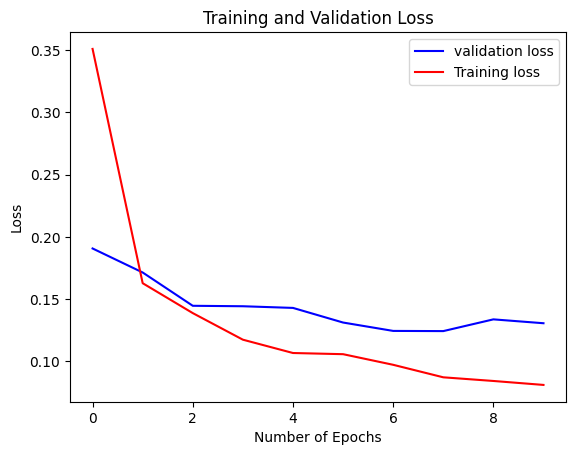

In [36]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

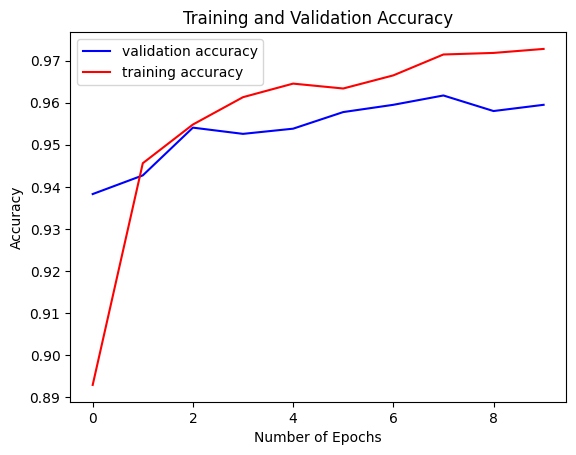

In [37]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="training accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [38]:
test_ds = test_ds.batch(Batch_size)
y_prob = ResNetModel.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)      #to get class index since we're using soft max

y_true = np.concatenate([y for x, y in test_ds], axis=0)   # true labels

64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step


In [39]:
# Evaluate model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc= accuracy_score(y_true, y_pred)
prec= precision_score(y_true, y_pred, average='macro')
rec= recall_score(y_true, y_pred, average='macro')
f1= f1_score(y_true, y_pred, average='macro')

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

Accuracy : 0.9614814814814815
Precision: 0.9610667185812284
Recall   : 0.9583720955866039
F1-score : 0.9593081418549794


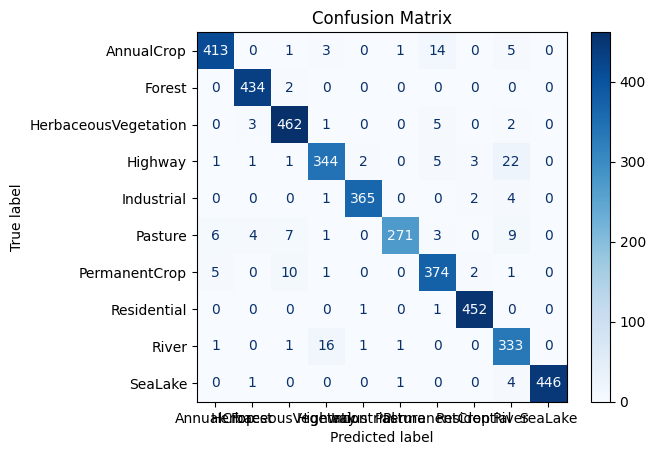

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# y_true must be one-hot / binarized
y_true_bin = label_binarize(y_true, classes=range(10))
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, multi_class="ovr", average="macro")
print("Macro-average ROC AUC:", roc_auc_macro)



Macro-average ROC AUC: 0.9990293421885157


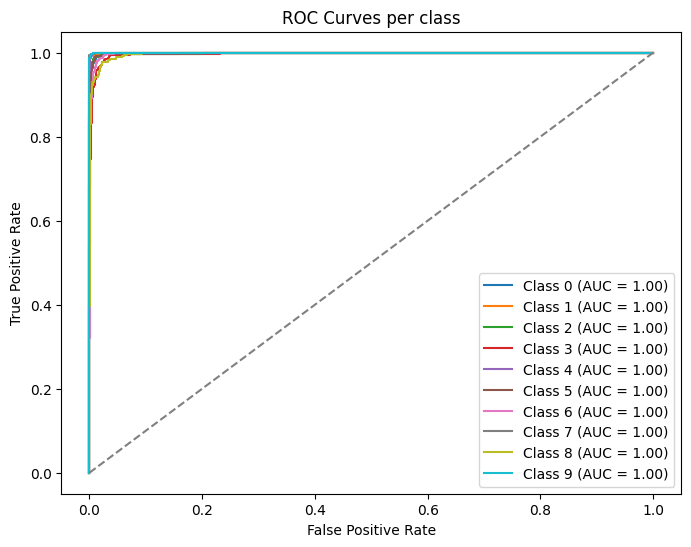

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per class")
plt.legend()
plt.show()